# 1 Dimensional DFT Code


* reference: https://github.com/tamuhey/python_1d_dft/blob/master/numpy_1ddft.ipynb 
* Try to adapt one dimensinal DFT Code using Jax

* Matrixdarstellung von Operatoren :
    * https://www.ph.tum.de/academics/bsc/break/2008s/fk_PH0007_03_course.pdf

For this we using the Hamiltonian: 

$$ \hat{H} = - \frac{1}{2} \frac{d²}{dx²} + \upsilon_{HA}(x) + v_x^{LDA} +x² $$

* where $v_x^{LDA}$ stands for *local density approximation*
* $\upsilon_{HA}(x)$ stands for the Coulomb Potential
* x² represents the harmonmic oscillator

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.scipy as jsci
from jax import grad, jit, vmap
from jax.ops import index, index_add, index_update
from jax import random
from jax.tree_util import partial

%matplotlib inline

## try to realize a Differential operator

bevor starting use a $f(x) = sin(x)$ to cacualte first and second derivation of $f(x)$


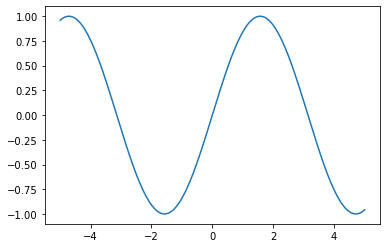

In [2]:
n_grid = 200
x = jnp.linspace(-5,5, n_grid, dtype=jnp.float64)
y = jnp.sin(x)
plt.plot(x,y)

### first derivation:
* in one dimension we can aproximate a differentiation by

$$(\frac{dy}{dx})_{i}=\frac{y_{i+1}-{y_{i}}}{h}$$

* so further the Matrix is: 

$$D_{ij}=\frac{\delta_{i+1,j}-\delta_{i,j}}{h}$$

* the reason of a Matix is here that there are Elements in the Dimension of $D_{i+1, j}$ so

* we could write as follows:

$$(\frac{dy}{dx})_{i}=D_{ij} y_{j}$$


* The derivative may not be well defined at the end of the grid.
* $\delta_{ij}$ is Kronecker delta
* Einstein summation is used for last equation
    


In [3]:
@jit
def diffOP_first(x):
    n_grid_loc = len(x)
    h=x[1]-x[0]
    delta_ip1_j = jnp.diagflat(jnp.ones(n_grid_loc-1),1) #create the Kronecker i+1, j 
    # jnp.diagflat Create a two-dimensional array with the flattened input as a diagonal.
    #    np.diagflat([1,2], 1)
    #    ==>    array([[0, 1, 0],
    #                  [0, 0, 2],
    #                  [0, 0, 0]])'

    delta_ij = jnp.eye(n_grid_loc) #crate the diagonal Elements

    # 1 in diagonal else 0 if k= 0 else k shift used diagonal
    #>>> np.eye(3, k=1) 
    #       array([[0.,  1.,  0.],
    #              [0.,  0.,  1.],
    #              [0.,  0.,  0.]])

    D = (delta_ip1_j -delta_ij)/ h #calc Differential operator D_ij
    return D

D = diffOP_first(x)

### Second order differentiation

* In the same way as the first order:

$$D^2_{ij}=\frac{\delta_{i+1,j}-2\delta_{i,j}+\delta_{i-1,j}}{h^2}$$

* This could be written with the first order $D_{ij}$, as follows (take care of the transpose):

$$D^2_{ij}=-D_{ik}D_{jk}$$

* The derivative may not be well defined at the end of the grid.


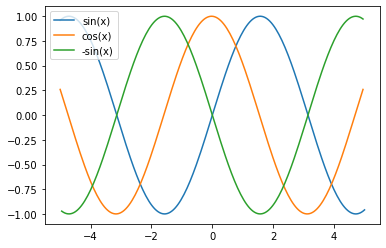

In [4]:
@jit
def diffOP_second(x, diffOP1 = False ):
    if diffOP1 is False:
        D = diffOP_first(x)
    else:
        D = diffOP1
    D2 = D.dot(-D.T)
    D2_new = index_update(D2, index[-1,-1], D2[0,0])
    return D2_new

D2 = diffOP_second(x, D)

diff_y = D.dot(y)
diff2_y = D2.dot(y)

plt.plot(x,y,label = 'sin(x)')
plt.plot(x[:-1],diff_y[:-1], label = 'cos(x)')
plt.plot(x[1:-1], diff2_y[1:-1] , label = '-sin(x)')
plt.legend(loc = "upper left")

# Non-interacting electrons
* This is the Hamiltonian of non-interacting free particles in a box given by the size of grid:
$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2}$$
* We could solve the KS equation by solving the eigenvalue problem
* using jsci.linalg.eigh() makes this pretty easy:

In [5]:
eig_non_e, psi_non_e = jsci.linalg.eigh(-D2/2)
# eig_non_e is the eingenvalue vom H psi = E psi
# psi_non_e is the wavefunktion psi 

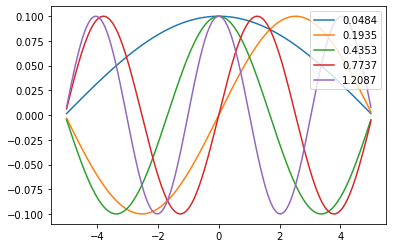

In [6]:
# ploted wavefunction (energies are shown in the label)
for i in range(5):
    plt.plot(x,psi_non_e[:,i], label=f"{eig_non_e[i]:.4f}")
    plt.legend(loc=1)

# Harmonic oscillator
* include the external potential $v_{ext}=x^2$:
$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2} + x^2$$

* we can write the potential as a matrix $X$, as follows:
$$ X = x^2 = \delta_{ij} x \cdot x$$

* after that we can again solfe the KS eq as eigenvalue Problem

In [7]:
X = jnp.diagflat(x*x)
eig_harm, psi_harm = np.linalg.eigh(-D2/2+X)

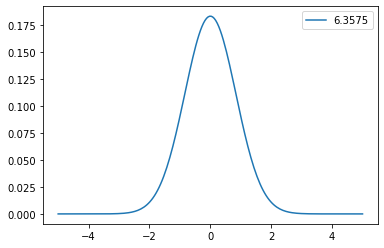

In [8]:
# ploted wavefunction (energies are shown in the label)

plt.plot(x,psi_harm[:,0], label=f"{eig_harm[i]:.4f}")
plt.legend(loc=1)

# Well potential 
(Potentialtopf)

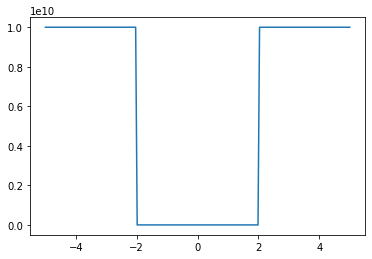

In [9]:
w_old =jnp.full_like(x,1.0e10) #creat array of len of array x 
w = index_update(w_old, index[jnp.logical_and(x>-2,x<2)], 0.)
plt.plot(x, w)

* Solve KS again adding the Well Potential but but without the harmonic part

In [10]:
eig_well, psi_well= jsci.linalg.eigh(-D2/2+jnp.diagflat(w))

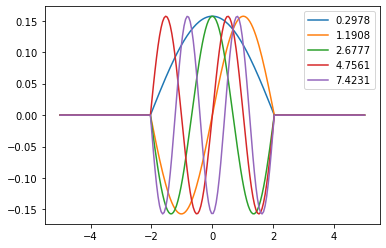

In [11]:
# ploted wavefunction (energies are shown in the label)
for i in range(5):
    plt.plot(x,psi_well[:,i], label=f"{eig_well[i]:.4f}")
    plt.legend(loc=1)

# Density
* We will want to include the Coulomb or Hatree interacion as well as LDA exchange
* Both of which are density functinals
* So we need to calculate the electron density
* Each state should be normalized:
$$\int \lvert \psi \rvert ^2 dx = 1$$

* let $f_n$ be occupation numbers, the density $n(x)$ can be written as follows:
$$n(x)=\sum_n f_n \lvert \psi(x) \rvert ^2 $$

* Note:
    - Each state fits up to two electrons: one with spin up, and one with spin down.
    - In DFT, we calculate the ground state.

In [12]:
# integral
@jit
def integral(x,y):
    dx = x[1]- x[0]
    return jnp.sum(y*dx, axis = 0)

- number of electrons

In [13]:
num_electrons = 17

* density

In [14]:
#@partial(jit , static_argnums = (1,))
@jit
def density(num_electron, psi , x):
    #norm the wave function:
    I = integral(x,psi**2)
    normed_psi = psi / jnp.sqrt(I)
    #follow the Hundschen rules to set up the 2 spins on the orbitals
    new_orb = False
    num_orb = num_electrons // 2
    
    if num_electrons % 2:
        new_orb = True
    
    fn_0 = jnp.full(num_orb + new_orb,2.) 
    
    if new_orb == True: 
        fn = index_update(fn_0, index[-1], 1)
    
    fnT = fn.reshape((-1,1))
    used_wavefunc = normed_psi.T[0:len(fn), :] 
    
    def dens(orb, wavefunc):
        return orb * (wavefunc**2)
    
    
    return jnp.sum(dens(fnT, used_wavefunc), axis = 0) 
    
    

%timeit density(num_electrons,psi_non_e, x)

74.5 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


[0.02355917 0.09310824 0.2053266  0.35489189 0.53478379 0.73668246
 0.95143652 1.16957164 1.38180836 1.57955766 1.75536456 1.90327387
 2.01909749 2.10056937 2.14738166 2.16110326 2.14498957 2.10369875
 2.04293565 1.96904852 1.88860572 1.80798025 1.73296849 1.66846608
 1.61821961 1.58466668 1.5688708  1.57055083 1.58819825 1.61926996
 1.66043969 1.70788773 1.75760711 1.80570399 1.84867166 1.88362036
 1.90844878 1.92194848 1.92383704 1.91472168 1.89599953 1.86970538
 1.83832088 1.80456131 1.77115702 1.74064602 1.71519274 1.69644519
 1.68543917 1.68255453 1.68752383 1.69949024 1.71710741 1.73867169
 1.76227462 1.78596291 1.80789308 1.82646898 1.8404523  1.84903888
 1.8518965  1.84916334 1.84140916 1.82956436 1.81482427 1.79853771
 1.78208955 1.76678726 1.75376023 1.74387965 1.7377041  1.73545425
 1.73701683 1.74197623 1.74966929 1.75925752 1.76980965 1.78038681
 1.79012298 1.79829389 1.80436923 1.80804431 1.80924969 1.80813909
 1.80505789 1.80049623 1.79503176 1.78926796 1.78377412 1.7790

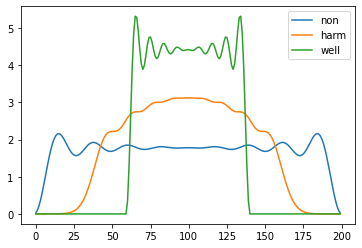

In [15]:
print(density(num_electrons,psi_non_e, x))
plt.plot(density(num_electrons,psi_non_e, x), label="non")
plt.plot(density(num_electrons,psi_harm, x), label="harm")
plt.plot(density(num_electrons,psi_well, x), label="well")
plt.legend(loc=1)

# Exchange energy
- Consider the exchange functional in the LDA: (to remember *local density approximation*)
    - ignore the correlation for simplicity.

$$ E_X^{LDA}[n] = -\frac{3}{4} \left(\frac{3}{\pi}\right)^{1/3} \int n^{4/3} dx$$

- The potential is given by the derivative of the exchange energy with respect to the density:

$$ v_X^{LDA}[n] = \frac{\partial E_X^{LDA}}{\partial n} = - \left(\frac{3}{\pi}\right)^{1/3} n^{1/3}$$

- the code is the following

In [16]:
@jit
def get_exchange(nx,x):
    energy=-3./4.*(3./jnp.pi)**(1./3.)*integral(x,nx**(4./3.))
    potential=-(3./jnp.pi)**(1./3.)*nx**(1./3.)
    return energy, potential


# coulomb potential
- Electrostatic energy or Hatree energy
- The expression of 3D-Hatree energy is not converged in 1D.
- Hence we cheat and use a modified as follows:
$$ E_{Ha}=\frac{1}{2}\iint \frac{n(x)n(x')}{\sqrt{(x-x')^2+\varepsilon}}dxdx'$$

    - where $\varepsilon$ is a small positive constant

- The potential is given by:
$$ v_{Ha}=\int \frac{n(x')}{\sqrt{(x-x')^2+\varepsilon}}dx'$$

- In a matirx expression:
$$E_{Ha} = \frac{1}{2} \frac{n_in_jh^2}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$
$$v_{Ha, i} = \frac{n_jh}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$

In [17]:
@jit
def get_hatree(nx,x, eps=1e-1):
    h = x[1]-x[0]
    
    energy = jnp.sum(nx[None,:]*nx[:,None]*h**2/jnp.sqrt((x[None,:]-x[:,None])**2+eps)/2)
    
    potential = jnp.sum(nx[None,:]*h/jnp.sqrt((x[None,:]-x[:,None])**2+eps),axis=-1)
    
    return energy, potential

# Solve the KS equation：Self-consistency loop
0. initialize the density (you can take an arbitrary constant) (beliebige constante kann verwendet werden)
1. Calculate the Exchange and Hatree potentials
2. Calculate the Hamiltonian
3. Calculate the wavefunctions and eigen values
4. If not converged, calculate the density and back to 1.

In [18]:
def print_log(i,log):
    print(f"step: {i:<5} energy: {log['energy'][-1]:<10.4f} energy_diff: {log['energy_diff'][-1]:.10f}")

In [19]:
max_iter=1000
energy_tolerance=1e-5
log={"energy":[float("inf")], "energy_diff":[float("inf")]}

In [20]:
@jit
def Energy_min(dens,x):
        ex_energy, ex_potential = get_exchange(dens, x)
        ha_energy, ha_potential = get_hatree(dens,x)
        
        # Hamiltonian
        H = -D2/2 + jnp.diagflat(ex_potential+ha_potential+x*x)
        
        energy, psi = jnp.linalg.eigh(H)
        return energy, psi

In [21]:
dens=jnp.zeros(n_grid)

for i in range(max_iter):
   
    energy, psi = Energy_min(dens,x)
    
    # log
    log["energy"].append(energy[0])
    energy_diff = energy[0]-log["energy"][-2]
    log["energy_diff"].append(energy_diff)
    print_log(i,log)
        # convergence
    
    if np.abs(energy_diff) < energy_tolerance:
        print("converged!")
        break
    
    # update density
    dens = density(num_electrons,psi,x)
else:
    print("not converged")


step: 0     energy: 0.7069     energy_diff: -inf
step: 1     energy: 16.3625    energy_diff: 15.6555321919
step: 2     energy: 13.8021    energy_diff: -2.5603559494
step: 3     energy: 15.3002    energy_diff: 1.4980525863
step: 4     energy: 14.4119    energy_diff: -0.8882287680
step: 5     energy: 14.9470    energy_diff: 0.5350438262
step: 6     energy: 14.6242    energy_diff: -0.3228271880
step: 7     energy: 14.8201    energy_diff: 0.1959328656
step: 8     energy: 14.7011    energy_diff: -0.1190355457
step: 9     energy: 14.7735    energy_diff: 0.0724651058
step: 10    energy: 14.7294    energy_diff: -0.0441312736
step: 11    energy: 14.7563    energy_diff: 0.0268946713
step: 12    energy: 14.7399    energy_diff: -0.0163922405
step: 13    energy: 14.7499    energy_diff: 0.0099933983
step: 14    energy: 14.7438    energy_diff: -0.0060926001
step: 15    energy: 14.7475    energy_diff: 0.0037147279
step: 16    energy: 14.7452    energy_diff: -0.0022649307
step: 17    energy: 14.7466   

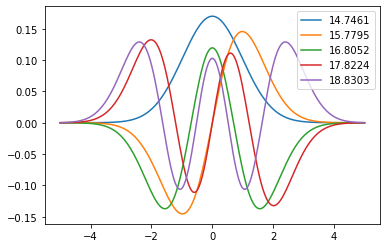

In [22]:
for i in range(5):
    plt.plot(x,psi[:,i], label = f"{energy[i]:.4f}")
    plt.legend(loc = 1)

* compare the density to free particles

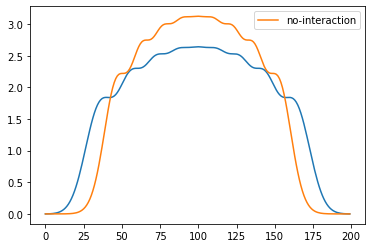

In [23]:
plt.plot(dens)
plt.plot(density(num_electrons,psi_harm,x), label="no-interaction")
plt.legend()

# Add external electric field:

* simulate an external electric potential like:

$$ V_{ext} = c \cdot x $$

* first take it simple and assume c is 0


In [24]:
def ext_E(x, c= 0):
    return x * c
